<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Lab #1: ES models </span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 
This is first laboratory task for the course TSA.
The Lab is desinged to impove skills of tuning parameters of ES models and get experience of coding of simple Regression Models.

The Lab should take about 5-6 hours to be completed.

<h1 align="center">Important Info</h1> 
- <span style="font-size: 14pt;"> You must send your solution to the email </span> <span style="color:red; font-size: 12pt;">alexromsput@gmail.com, </span>
- The theme of your message must be <span style="color:red; font-size: 12pt;"> TSA-Erevan-2017-[Your Surname] </span>, for exmaple -- TSA-Erevan-2017-Romanenko,
- You can send ipnb file in attachment or just a link to github. The file in attachment of the letter must be named as <span style="color:red; font-size: 12pt;"> [Surname]-[Group]-Lab1.ipnb</span>, for example -- Romanenko-Evening-Lab1.ipnb,
  
<span style="color:red; font-size: 14pt;"> DEADLINE: 10 June 2017 23:59:59 </span>


<h1 align="center">1. Using ARIMA for wage and electricity comsumption datasets (50%)</h1>
Solve the task for Practice day 2.

look practice1 folder

<h1 align="center">2. Forecasting of real TS (50%)</h1>
Build the forecast for a dataset  according to the scheme in task 2 (in Practice day 2). You can find the link to dataset that you need to forecast at the sheet 'Lab2' <a href="https://drive.google.com/open?id=11-lzxxR0aeBmEDGEW1GiIaP4X3fyCTHxTg4b0wALpzs">here</a>. 
     


In [1]:
import time
import numpy as np
from datetime import datetime, timedelta
import pylab
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import math
import pandas.tseries.offsets as ofs
from scipy import stats
import statsmodels.api as sm

import warnings as w
import plotly.plotly as py
from IPython.display import Image

%matplotlib inline

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m')

labor = pd.read_csv('./civilian-labour-force-in-austral.csv', sep=',', decimal='.', parse_dates=['Date'],
                    date_parser=dateparse, index_col='Date')

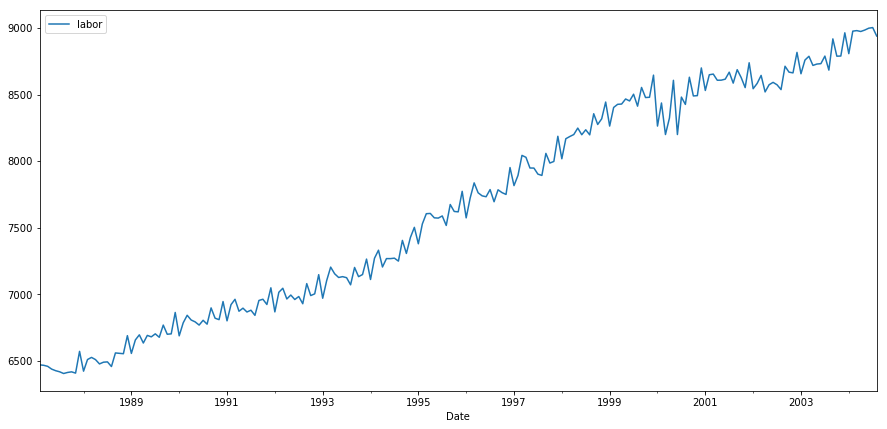

In [3]:
labor.plot(figsize = (15,7))

In [4]:
labor =  labor.loc['1989.01.01':]
labor.head()

,labor
Date,
1989-01-01,6554.6
1989-02-01,6655.8
1989-03-01,6694.3
1989-04-01,6632.8
1989-05-01,6690.0


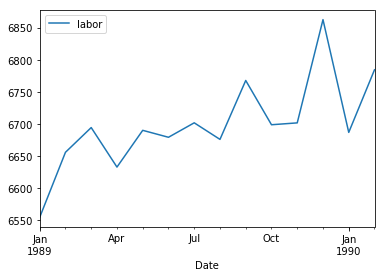

In [37]:
labor_train =labor.loc['1989.01.01':'2001.01.01']
labor_test = labor.loc['2001.01.01':'2005-01-01']
labor.loc['1987.02.01':'1990.02.01'].plot()

we have yearly seasonality and trend

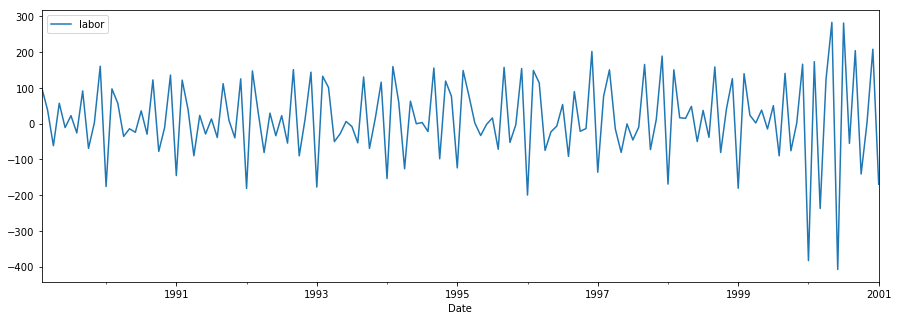

In [6]:
p = 1
diff_labor = (labor_train - labor_train.shift(p))[p:]
diff_labor.plot(figsize=(15,5))

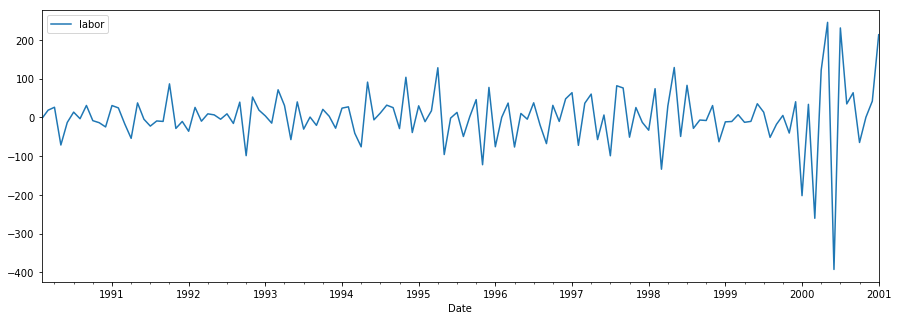

In [7]:
p = 12
sdiff_labor = (diff_labor - diff_labor.shift(p))[p:]
sdiff_labor.plot(figsize=(15,5))

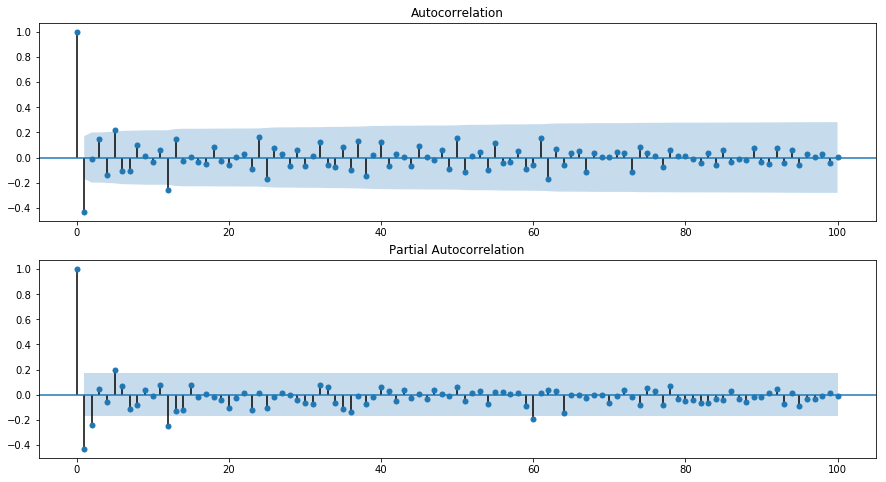

In [8]:
ts = sdiff_labor
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts.values.squeeze(), lags=100, ax=ax2)

sems to be stationary

In [9]:
mod = sm.tsa.statespace.SARIMAX(labor_train, trend='n', order=(8,1,8), seasonal_order=(4,1,2,12), enforce_invertibility=False)
results = mod.fit()

/home/hp/anaconda3/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [10]:
results.aic

1481.5476996263546

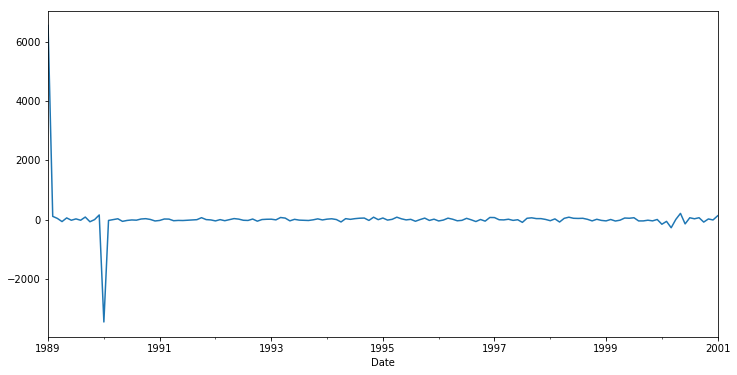

In [11]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax = results.resid.plot(ax=ax)

In [12]:
# Darbin_Watson statistic
sm.stats.durbin_watson(results.resid.values)

1.213717108985098

In [13]:
stat = stats.wilcoxon(results.resid.values)
print('Statistic: %f\npvalue: %.2f' %(stat[0], stat[1]))

Statistic: 4764.000000
pvalue: 0.30


In [14]:
# Normal test
resid = results.resid
stats.normaltest(resid)

NormaltestResult(statistic=240.88127429729965, pvalue=4.9350992297786294e-53)

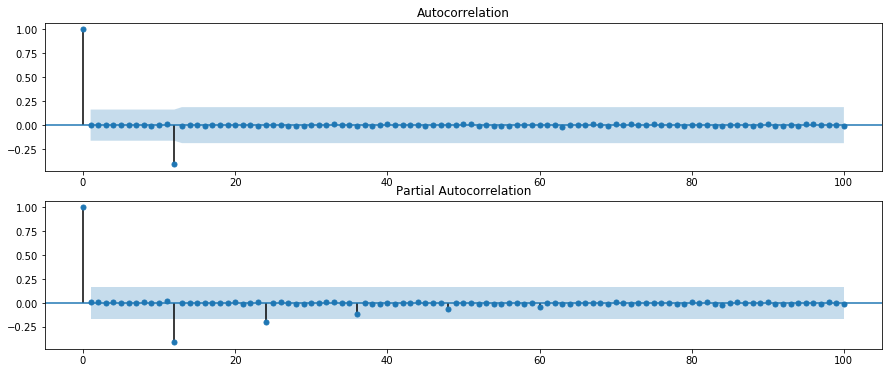

In [15]:
resid = results.resid
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=100, ax=ax2)

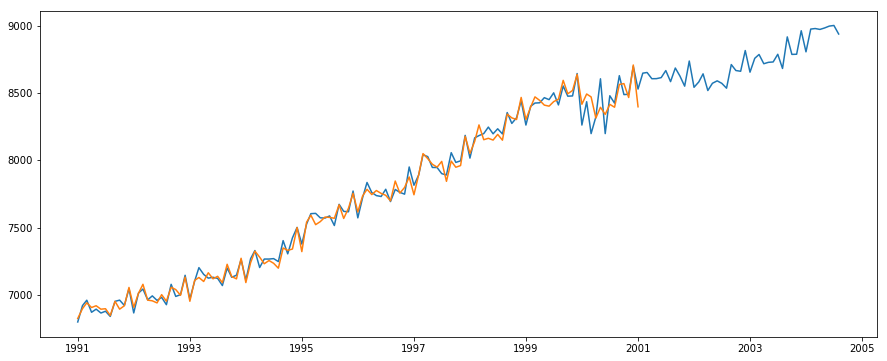

In [16]:
frc_arma = results.predict()
frc_arma = frc_arma.to_frame('labor')
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
plt.plot(labor.loc['1991.01.01':])
ax2 = fig.add_subplot(111)
plt.plot(frc_arma.loc['1991.01.01':])

In [17]:
def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

def qualityMACAPE(x,y):
    # Mean average corrected absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , (x-y).abs()

In [32]:
prediction = results.predict('2001.01.01', '2005-01-01', dynamic=False)

In [33]:
prediction = prediction.to_frame('labor')
prediction.index.name = 'Date'

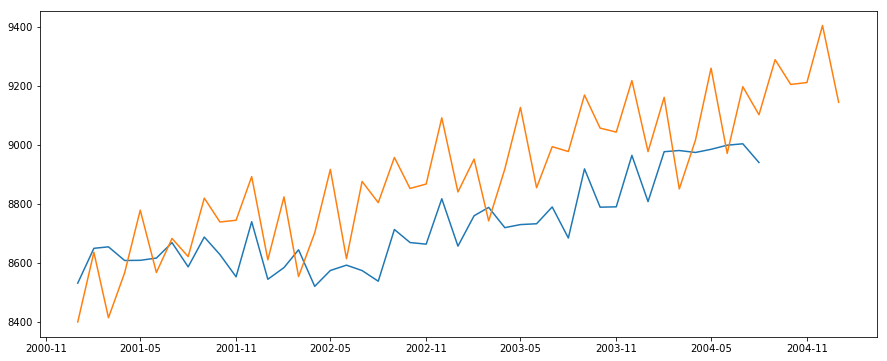

In [38]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
plt.plot(labor_test)
ax2 = fig.add_subplot(111)
plt.plot(prediction)

In [34]:
frc_arma.index.name = 'Date'
qualityMAPE(prediction.loc['1991.01.01':], labor_test.loc['1991.01.01':])[0]

labor    0.019229
dtype: float64

In [35]:
qualityMACAPE(prediction.loc['1991.01.01':], labor_test.loc['1991.01.01':])[0]

labor    0.019439
dtype: float64